In [98]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Exoplanet Detection ML Pipeline - NASA Space App Challenge")
print("=" * 60)
df = pd.read_csv(r'E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\KOI\koi_data.csv', comment='#')

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['koi_disposition'].value_counts())
print(f"\nFirst 5 rows:")
print(df.head())

Exoplanet Detection ML Pipeline - NASA Space App Challenge
Dataset loaded successfully!
Dataset shape: (9564, 49)

Target variable distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

First 5 rows:
      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0     

In [100]:
print("\nBlock 2: Data Quality Assessment")

# Check for missing values
print("Missing values per column:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Basic statistics
print(f"\nDataset Info:")
print(df.info())


Block 2: Data Quality Assessment
Missing values per column:
                   Missing Count  Percentage
koi_teq_err1                9564  100.000000
koi_teq_err2                9564  100.000000
kepler_name                 6817   71.277708
koi_score                   1510   15.788373
koi_steff_err2               483    5.050188
koi_srad_err1                468    4.893350
koi_steff_err1               468    4.893350
koi_slogg_err2               468    4.893350
koi_slogg_err1               468    4.893350
koi_srad_err2                468    4.893350
koi_time0bk_err1             454    4.746968
koi_period_err1              454    4.746968
koi_period_err2              454    4.746968
koi_time0bk_err2             454    4.746968
koi_impact_err1              454    4.746968
koi_depth_err1               454    4.746968
koi_depth_err2               454    4.746968
koi_duration_err1            454    4.746968
koi_duration_err2            454    4.746968
koi_impact_err2              454    4.7

In [101]:

print("\nBlock 3: Data Preprocessing")

# Create a copy for preprocessing
df_processed = df.copy()

# Define feature columns (excluding ID and target)
feature_columns = [col for col in df_processed.columns if col not in ['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition']]

print(f"Feature columns identified: {len(feature_columns)} features")
print(f"Features: {feature_columns}")

# Handle missing values
print("\n🔧 Handling missing values...")

# Separate numeric and categorical features
numeric_features = df_processed[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_processed[feature_columns].select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Impute missing values for numeric features
if len(numeric_features) > 0:
    print("Imputing numeric features...")
    for col in numeric_features:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
            print(f"  - {col}: filled {df_processed[col].isnull().sum()} missing values")

# Impute missing values for categorical features
if len(categorical_features) > 0:
    print("Imputing categorical features...")
    for col in categorical_features:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode().iloc[0] if not df_processed[col].mode().empty else 'Unknown'
            df_processed[col] = df_processed[col].fillna(mode_val)
            print(f"  - {col}: filled {df_processed[col].isnull().sum()} missing values")

print("Missing values handled")

# Prepare target variable
target_encoder = LabelEncoder()
df_processed['target_encoded'] = target_encoder.fit_transform(df_processed['koi_disposition'])

print(f"\nTarget encoding:")
for i, label in enumerate(target_encoder.classes_):
    print(f"{i}: {label}")


Block 3: Data Preprocessing
Feature columns identified: 44 features
Features: ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

🔧 Handling missing values...
Numeric features: 43
Categorical features: 1
Imputing numeric features...
  - koi_score: filled 0 missing values
  - koi_period_err1: filled 0 missing values
  - koi_period_err


Block 4: Exploratory Data Analysis


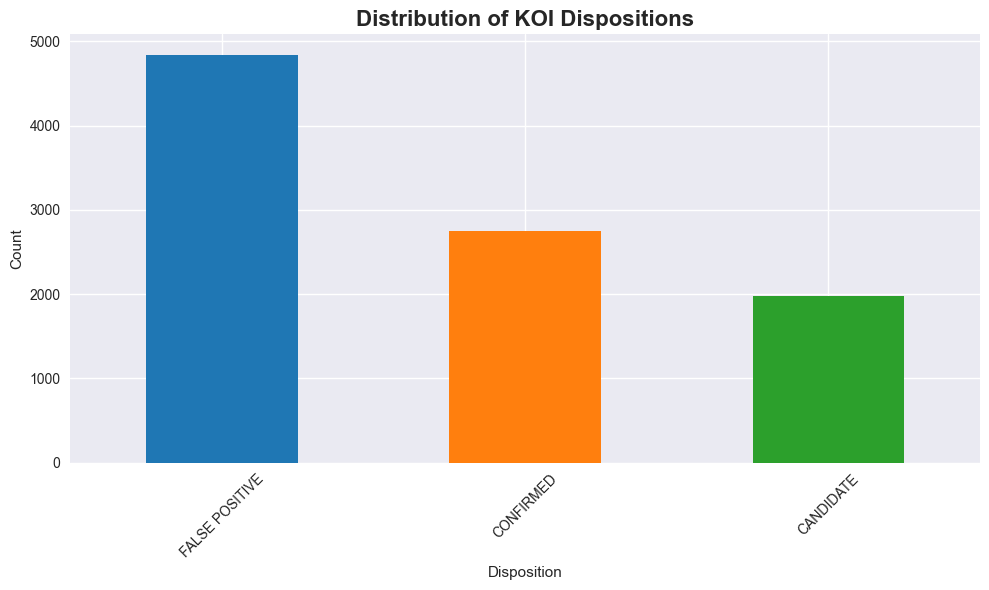

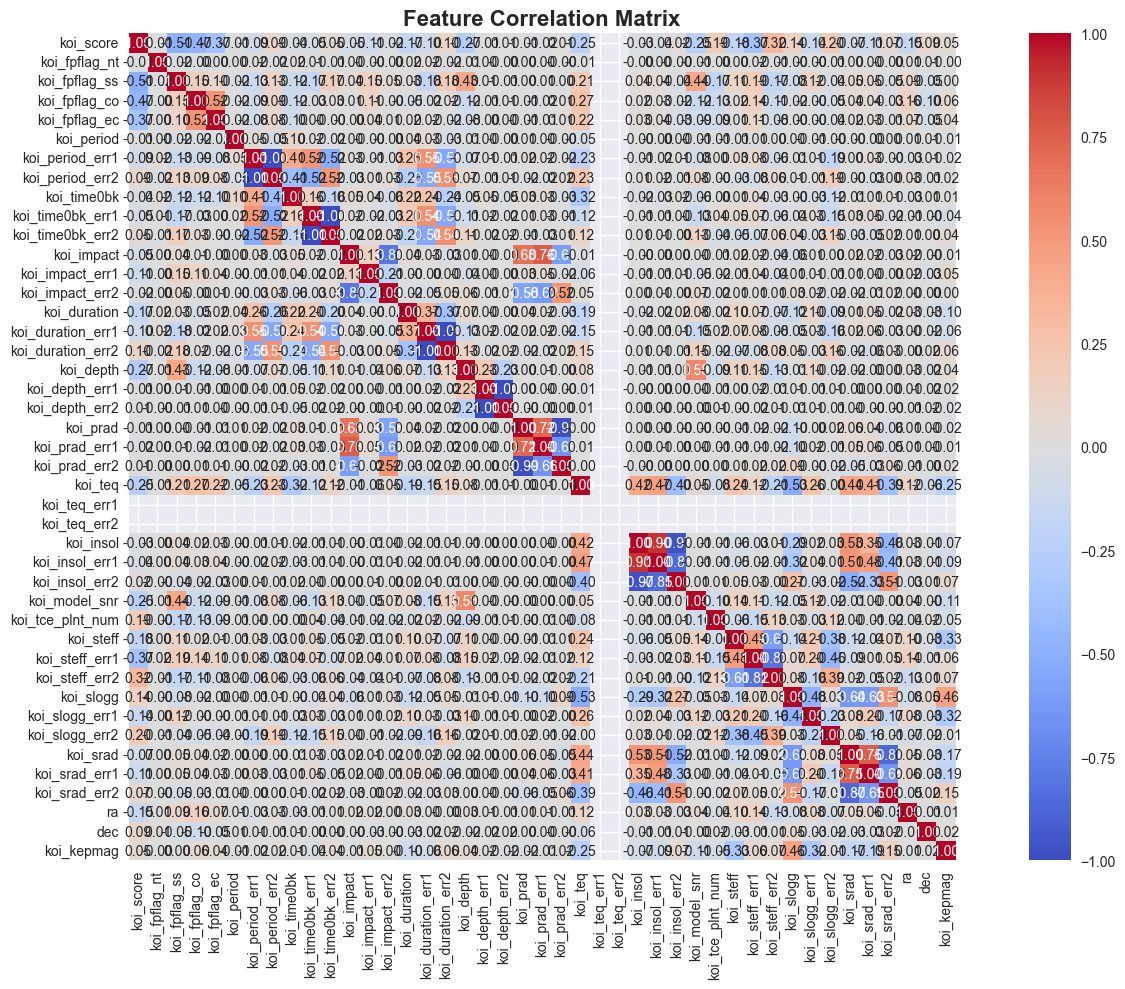

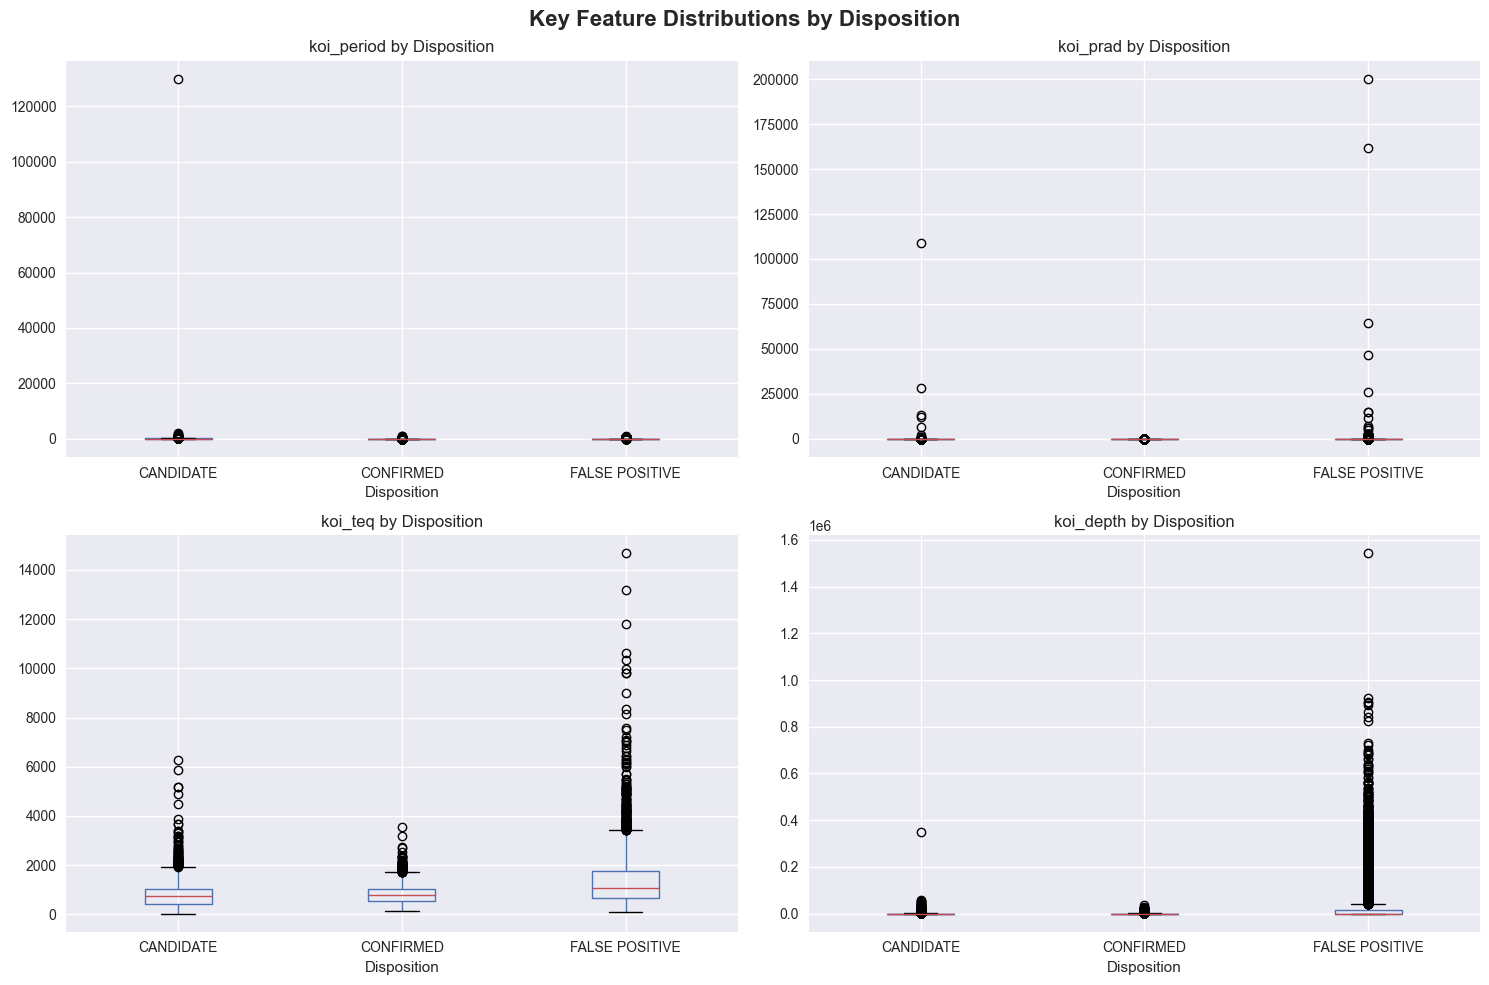

In [102]:

print("\nBlock 4: Exploratory Data Analysis")

# Set up plotting style
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)

# Target distribution
plt.figure(figsize=(10, 6))
df['koi_disposition'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Distribution of KOI Dispositions', fontsize=16, fontweight='bold')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
if len(numeric_features) > 5: 
    plt.figure(figsize=fig_size)
    correlation_matrix = df_processed[numeric_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Distribution of key features
key_features = ['koi_period', 'koi_prad', 'koi_teq', 'koi_depth', 'koi_model_snr']
available_key_features = [f for f in key_features if f in numeric_features]

if len(available_key_features) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.ravel()
    
    for i, feature in enumerate(available_key_features[:4]):
        df_processed.boxplot(column=feature, by='koi_disposition', ax=axes[i])
        axes[i].set_title(f'{feature} by Disposition')
        axes[i].set_xlabel('Disposition')
    
    plt.suptitle('Key Feature Distributions by Disposition', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()